In [1]:
%pylab inline
import astropy.cosmology as aco
import astropy.units as au
import astropy.coordinates as ac
from scipy.interpolate import interp1d, RegularGridInterpolator
import h5py as h5

Populating the interactive namespace from numpy and matplotlib


In [2]:
final_sel=np.load("selection_2mpp.npy")

density2 = None
density_err = None

if False:
    chain_summary=np.load("/data/lavaux/stats.npz")
    density = chain_summary['d'][0]
    density_err = chain_summary['d'][1]
else:
    with h5.File("./output_9840.h5", mode="r") as ff:
        density = ff['dmsheet_density'][...]
        #we save the useful information for us in an array
        #density /= 1e-26
        #Here we load the information(density contrast) at each coordinate in space in matrix density

In [3]:
L=677.7 #Given the distribution length of density in each direction 
N=density.shape[0]

corner=-338.85

ix=(np.arange(N)+0.5)*L/N+corner
x = ix[:,None,None].repeat(N,axis=1).repeat(N,axis=2)
y = ix[None,:,None].repeat(N,axis=0).repeat(N,axis=2)
z = ix[None,None,:].repeat(N,axis=0).repeat(N,axis=1)
#we set each coordinate of the points in space in 3 matrices

In [4]:
def integrateLOS(matrix, E):
    matrix2 = np.zeros((8, 8, 128))
    mat = np.zeros(128)
    for i in range(0, 8):
        for j in range(0, 8):
            for r in range(0, 128):
                r1 = r * 4 
                t0 = matrix[i][j][r1]
                t1 = matrix[i][j][r1+1]
                t2 = matrix[i][j][r1+2]
                t3 = matrix[i][j][r1+3]
                #Y = t0* (E[r1+1]- E[r1])+ t1* (E[r1+2]- E[r1+1])+ t2* (E[r1+3]- E[r1+2])+ t3* (E[r1+4]- E[r1+3])
                mat[r] = t0*(E[r1+1]- E[r1])+ t1*(E[r1+2]- E[r1+1])+ t2*(E[r1+3]- E[r1+2])+ t3*(E[r1+4]- E[r1+3])
                #matrix2[i][j].append(D)
            #mat.pop()
            #mat.append(mat[126])
            #mat1 = np.asarray(mat)
            #np.append(matrix2, mat1, axis=2)
            #print(mat1.shape)
            #print(matrix2.shape)
            #mat = matt
            matrix2[i][j][:] =  mat
            #mat.clear()
            
    return matrix2        
#this function devides the distance into regions with different redshifts
#then integrate the number of photons in each shell
#the last problem faced that prevented from improving where the matrix

In [5]:
def integrateLOS(matrix, E):
    matrix2 = np.zeros((80, 80, 128))
    mat = np.zeros(128)
    for i in range(0, 80):
        for j in range(0, 80):
            for r in range(0, 128):
                r1 = r * 4 
                t0 = matrix[i][j][r1]
                t1 = matrix[i][j][r1+1]
                t2 = matrix[i][j][r1+2]
                t3 = matrix[i][j][r1+3]
                #Y = t0* (E[r1+1]- E[r1])+ t1* (E[r1+2]- E[r1+1])+ t2* (E[r1+3]- E[r1+2])+ t3* (E[r1+4]- E[r1+3])
                mat[r] = t0*(E[r1+1]- E[r1])+ t1*(E[r1+2]- E[r1+1])+ t2*(E[r1+3]- E[r1+2])+ t3*(E[r1+4]- E[r1+3])
                
            matrix2[i][j][:] =  mat
    return matrix2

In [6]:
#matrix = np.ones((8, 8, 512))
#E = np.linspace(1,300,513)
#m2 = integrateLOS(matrix, E)
#m3 = mat3d1d(matrix, 100)
#print(m2)
#test

In [6]:
def rad(ms, sintheta, rap, decp):#ms in kev
    #distp = distance * 512 / 300
    #distp = distp // 4
    dists1 = np.linspace(1,300,512) #Here I divide the distances form us as a grid
    #dists1sp = np.array_split(dists1, 102) # then I divide the distances into regions for each redshift
    from astropy.cosmology import WMAP9 as cosmo
    H0 = (cosmo.H(0) * 1e5).value
    #H0 = H0 *au.cm /au.Mpc /au.s
    pi = math.pi
    C = 2.9979e10 #* au.cm
    width = 5.6e-22 * (sintheta)**2 *(ms)**5 #*1/au.s
    A = width /(4 * pi * H0)
    dists = dists1*au.Mpc #the constant multiplied by the needed variable to integrate on
    E = [512]
    dE = [512]
    Nph = np.zeros((8, 8, 128))
    x_l = ix[:]
    y_l = ix[:]
    z_l = ix[:]
    dNph = np.zeros((8, 8, 512))
    for i in range(0, 512):
        E.append(1./(2*(H0* dists1[i] /C + 1)))
        dE.append((H0/C)*(300/512)/(2*(H0* dists1[i] /C + 1)**2))
        #E.append(E1)
        #dE1.append(dE1)
    #print(dE)
    #Esp = np.array_split(E, 102)
    #dEsp = np.array_split(dE, 102)
    #E *= ms
    #dE = E/1200
    for ra1 in range(rap - 4, rap + 4):
        
        for dec1 in range (decp - 4,decp + 4):
            ra2 = ra1 - rap + 4 
            dec2 = dec1 - decp +4 #different directions changed by the for loop
            
            ra,dec=ra1*au.deg, dec1*au.deg
            coords = ac.ICRS(ra=ra,dec=dec,distance=dists) 
            #change the coordinates of point alonge the line of sight from spherical to cartisian coordinate
            xyz = coords.cartesian.xyz.value.transpose()
            los_density = RegularGridInterpolator((x_l,y_l, z_l),density, method='linear', bounds_error=True, fill_value=nan)(xyz)
            los_density += 1
            los_density *= 1e-23 #* au.g / au.m**3
            #the density of DM over the line of sight(LOS) after interpolating it with the coordinates of pointes along the LOS
            #los_densitysp = np.array_split(los_density, 102)
            for r in range(0, 512):
                
                dNph[ra2][dec2][r] = los_density[r] * math.sqrt(2 * E[r])**3 /math.sqrt(0.7*8 * E[r]**3 + 0.3 * ms**3)
                #Nph[ra1][dec1][r] += dE[j] * dNph[j]
                #using the formula mentioned previously in the paper
    dNph *= A
    Nph = integrateLOS(dNph, E)
    #S = Nph[: ,: , 100]      
    return Nph

In [8]:
def rad(ms, sintheta, rap, decp):#ms in kev
    #distp = distance * 512 / 300
    #distp = distp // 4
    dists1 = np.linspace(1,300,512) #Here I divide the distances form us as a grid
    #dists1sp = np.array_split(dists1, 102) # then I divide the distances into regions for each redshift
    from astropy.cosmology import WMAP9 as cosmo
    H0 = (cosmo.H(0) * 1e5).value
    #H0 = H0 *au.cm /au.Mpc /au.s
    pi = math.pi
    C = 2.9979e10 #* au.cm
    width = 5.6e-22 * (sintheta)**2 *(ms)**5 #*1/au.s
    A = width /(4 * pi * H0)
    dists = dists1*au.Mpc #the constant multiplied by the needed variable to integrate on
    E = [512]
    dE = [512]
    Nph = np.zeros((80, 80, 128))
    x_l = ix[:]
    y_l = ix[:]
    z_l = ix[:]
    dNph = np.zeros((80, 80, 512))
    for i in range(0, 512):
        E.append(1./(2*(H0* dists1[i] /C + 1)))
        dE.append((H0/C)*(300/512)/(2*(H0* dists1[i] /C + 1)**2))
        #E.append(E1)
        #dE1.append(dE1)
    #print(dE)
    #Esp = np.array_split(E, 102)
    #dEsp = np.array_split(dE, 102)
    #E *= ms
    #dE = E/1200
    for ii in range(0, 80):
        
        for jj in range (0, 80):

            ra1 = rap - 4 + 0.1*ii
            dec1 = decp - 4 + 0.1*jj #different directions changed by the for loop
            
            ra,dec=ra1*au.deg, dec1*au.deg
            coords = ac.ICRS(ra=ra,dec=dec,distance=dists) 
            #change the coordinates of point alonge the line of sight from spherical to cartisian coordinate
            xyz = coords.cartesian.xyz.value.transpose()
            los_density = RegularGridInterpolator((x_l,y_l, z_l),density, method='linear', bounds_error=True, fill_value=nan)(xyz)
            los_density += 1
            los_density *= 1e-23 #* au.g / au.m**3
            #the density of DM over the line of sight(LOS) after interpolating it with the coordinates of pointes along the LOS
            #los_densitysp = np.array_split(los_density, 102)
            for r in range(0, 512):
                
                dNph[ii][jj][r] = los_density[r] * math.sqrt(2 * E[r])**3 /math.sqrt(0.7*8 * E[r]**3 + 0.3 * ms**3)
                #Nph[ra1][dec1][r] += dE[j] * dNph[j]
                #using the formula mentioned previously in the paper
    dNph *= A
    Nph = integrateLOS(dNph, E)
    #S = Nph[: ,: , 100]      
    return Nph

In [7]:
A = rad(34, 126, 195, 28)
S = A[: ,: , 44]
#coma cluster

IndexError: index 8 is out of bounds for axis 0 with size 8

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline


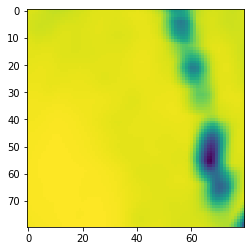

In [11]:
plt.imshow(S)

In [13]:
A = rad(34, 126, 195, 28)
SS = A[: ,: , 28]
#coma cluster

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline


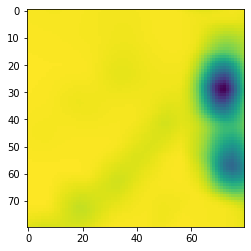

In [15]:
plt.imshow(SS)

In [20]:
#for i in range (1, 128):
 #   import matplotlib.pyplot as plt
  #  %matplotlib inline
   # S = A[: ,: , i]
    #plt.imshow(S)
    

In [16]:
A1 = rad(34, 126, 187, 13)
S1 = A1[: ,: , 9]
#virgo cluster

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

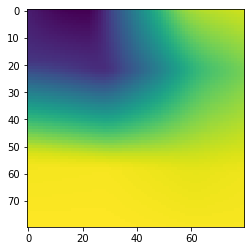

In [18]:
plt.imshow(S1)

In [21]:
A2 = rad(34, 126, 192, 41)
S2 = A2[: ,: , 22]
#Centaurus cluster d=

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

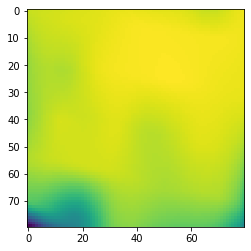

In [23]:
plt.imshow(S2)

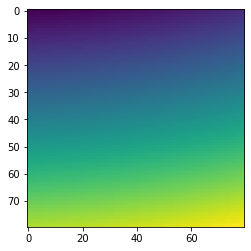

In [25]:
Aa = rad(34, 126, 75, 5)
Ss = A[: ,: , 0]
#coma cluster
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(Ss)